# Homework
### Data preparation

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold

from tqdm.auto import tqdm

In [169]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')

In [170]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
numerical_columns = list(df.dtypes[df.dtypes != 'object'].index)

In [171]:
for col in df.columns:
	if col in categorical_columns:
	  df[col] = df[col].fillna('NA')
	if col in numerical_columns:
	  df[col] = df[col].fillna(0)

In [172]:
assert (len(numerical_columns) + len(categorical_columns)) == df.shape[1]

In [173]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

In [174]:
numerical_columns.remove('converted')

### Question 1: ROC AUC feature importance

In [175]:
for col in numerical_columns:
	y_score = df_train[col]
	score = roc_auc_score(y_train, y_score)

	print(f"Predictor variable: {col}, ROC-AUC score: {score:3f}")

Predictor variable: number_of_courses_viewed, ROC-AUC score: 0.763568
Predictor variable: annual_income, ROC-AUC score: 0.551958
Predictor variable: interaction_count, ROC-AUC score: 0.738270
Predictor variable: lead_score, ROC-AUC score: 0.614499


### Question 2: Training the model

In [176]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [177]:
val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

In [178]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
round(auc(fpr, tpr), 3)

0.817

### Question 3: Precision and Recall

In [179]:
precision_scores = []
recall_scores = []
f1_scores = []

In [180]:
thresholds = np.linspace(0.0, 1.0, 101)

In [181]:
for i, t in enumerate(thresholds):
	precision = precision_score(y_val, y_pred >= t, zero_division=np.nan)
	recall = recall_score(y_val, y_pred >= t, zero_division=np.nan)
	precision_scores.append(precision)
	recall_scores.append(recall)
	f1 = f1_score(y_val, y_pred >= t)
	f1_scores.append({'threshold': t, 'score': f1})

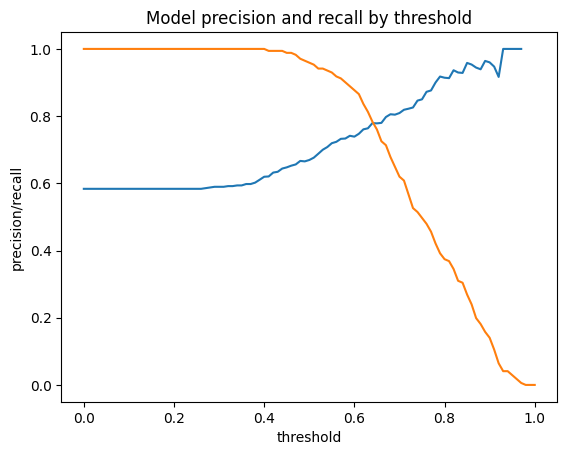

In [182]:
plt.title('Model precision and recall by threshold')
plt.xlabel('threshold')
plt.ylabel('precision/recall')
plt.plot(thresholds, precision_scores)
plt.plot(thresholds, recall_scores)
plt.show()

### Question 4: F1 score

In [183]:
f1_df = pd.DataFrame(data=f1_scores)

In [184]:
f1_df.loc[f1_df.threshold.isin([.14, .34, .54, .74]), :].sort_values('score', ascending=False)

,threshold,score
54,0.54,0.806045
34,0.34,0.745098
14,0.14,0.737069
74,0.74,0.640000


### Question 5: 5-Fold CV

In [185]:
def train(df_train, y_train, model):
    dicts = df_train[categorical_columns + numerical_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model.fit(X_train, y_train)

    return dv, model

In [186]:
def predict(df, dv, model):
    dicts = df[categorical_columns + numerical_columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [187]:
n_splits = 5
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [188]:
scores = []

In [189]:
for train_idx, val_idx in kfold.split(df_full_train):
	df_train = df_full_train.iloc[train_idx]
	df_val = df_full_train.iloc[val_idx]

	y_train = df_train.converted.values
	y_val = df_val.converted.values

	model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
	dv, model = train(df_train, y_train, model)
	y_pred = predict(df_val, dv, model)

	auc_score = roc_auc_score(y_val, y_pred)
	scores.append(auc_score)

In [190]:
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.822 +- 0.036


### Question 6: Hyperparameter Tuning

In [191]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        dv, model = train(df_train, y_train, model)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.560 +- 0.024
C=0.001 0.867 +- 0.029
C=1 0.822 +- 0.036
